# Modèle de Classification des genres musicaux

Notebook Classification des genres musicaux :
https://www.kaggle.com/code/danielsheen/spotify-song-genre-classification \
Google Doc rapport :
https://docs.google.com/document/d/1M9s9FF17sJEX5S9xx0gOnQsSh5BbSACHqFkQKUZUak4/edit?tab=t.0 \
Dataset : https://www.kaggle.com/code/sonawanelalitsunil/900k-spotify-songs-with-lyrics-emotions


Analyse Pré-traitement

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [10]:
spotify_df = pd.read_csv("Dataset/spotify_dataset_class_balanced.csv")
# spotify_df = spotify_df.sample(n=10000, random_state=42)
# # On garde seulement 80% des données à extraire
spotify_df_80, spotify_df_20= train_test_split(spotify_df, test_size=0.2, random_state=42)


In [11]:
numerical_features = [
    'Tempo',
    'Loudness (db)',
    'Energy',
    'Danceability',
    'Positiveness',
    'Speechiness',
    'Liveness',
    'Acousticness',
    'Instrumentalness',
    'Length',
    'text'
]

categorical_features = [
    'Key',
    'Time signature',
    'emotion'
]

y = spotify_df_80["Main_genre_index"]
X = spotify_df_80[numerical_features + categorical_features ]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2 )


In [12]:


# 2. Prétraitement des données
preprocessing = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),categorical_features)
])

preprocessing.fit(X_train)
X_train_pp = preprocessing.transform(X_train)
X_test_pp = preprocessing.transform(X_test)
print(X_test_pp[0])

[ 1.24073332  0.0593871   1.65286249 -2.92054576 -1.09516628 -0.04215262
 -0.71750533 -0.83876932  3.84178305 -0.8822754  -1.19709398  0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.        ]


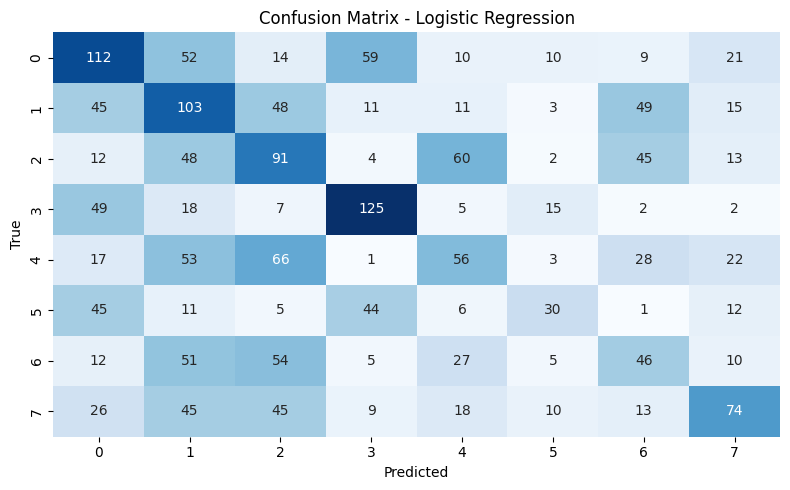

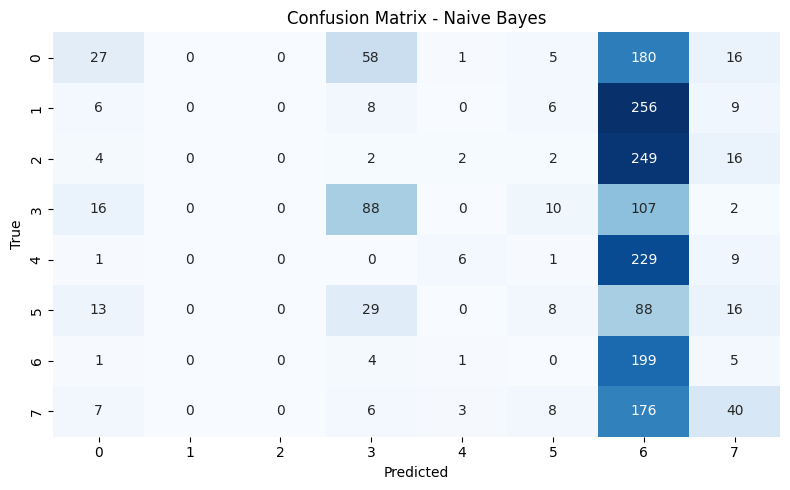

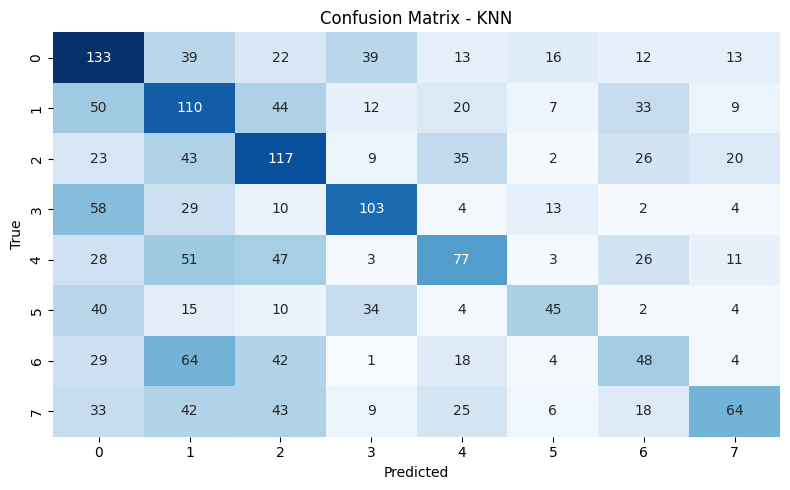

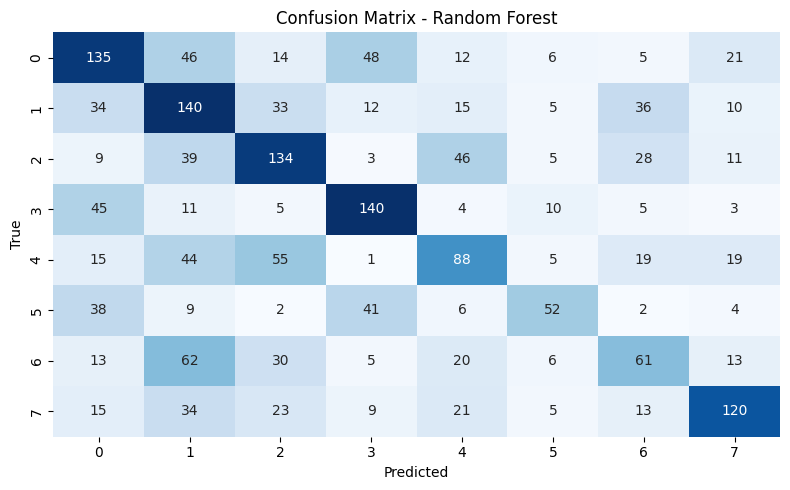

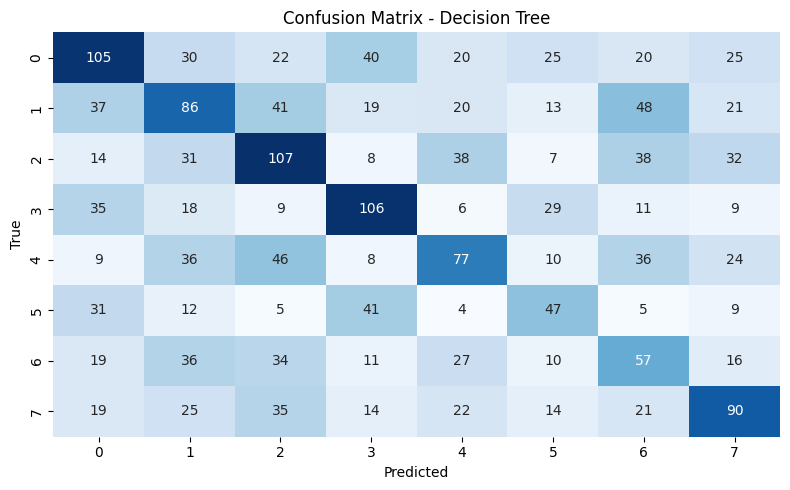

In [13]:
import math

# Modèles
models = [
    LogisticRegression(max_iter=1000),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5),
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier(random_state=42)  # Remplace MLP
]

model_names = [
    'Logistic Regression',
    'Naive Bayes',
    'KNN',
    'Random Forest',
    'Decision Tree'  # Remplace 'MLP'
]

# Initialisation
n = len(models)
acc_train = [0] * n
acc_test = [0] * n
acc_cv = [0] * n
model_preci = [0] * n
model_recall = [0] * n
model_f1 = [0] * n
y_train_preds = dict()
y_test_preds = dict()

# Boucle sur les modèles
for i in range(n):
    name = model_names[i]
    models[i].fit(X_train_pp, y_train)
    y_train_pred = models[i].predict(X_train_pp)
    y_test_pred = models[i].predict(X_test_pp)

    # Stock des prédictions
    y_train_preds[name] = y_train_pred
    y_test_preds[name] = y_test_pred
    
    acc_train[i] = accuracy_score(y_train, y_train_pred)
    acc_test[i] = accuracy_score(y_test, y_test_pred)
    if(name=="SVM" or name=="MLP"):
        acc_cv[i] = 0
    else:
        acc_cv[i] = np.mean(cross_val_score(models[i], X_train_pp, y_train, cv=5, scoring='accuracy'))

    model_preci[i] = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    model_recall[i] = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    model_f1[i] = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {model_names[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()




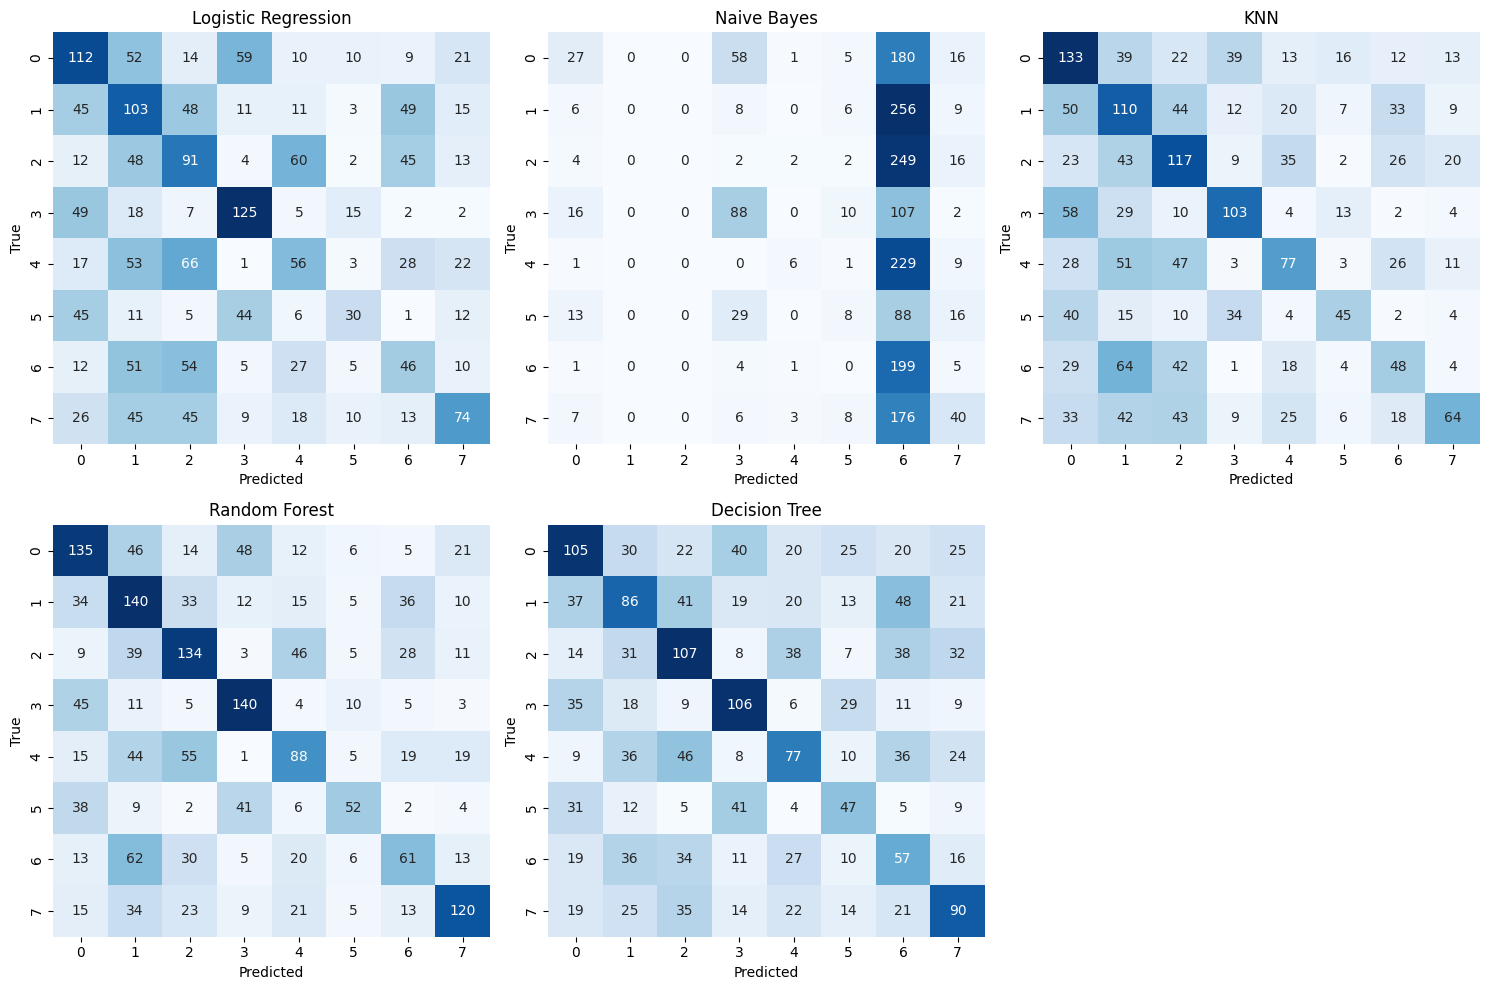

In [14]:
# Affichage des matrices de confusion en subplots
rows = 2
cols = math.ceil(n / rows)  # arrondi supérieur : ici 3 colonnes

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

axes = axes.flatten()  # pour accéder aux subplots avec axes[i]
for i in range(n):
    name = model_names[i]
    y_test_pred = y_test_preds[name]
    cm = confusion_matrix(y_test, y_test_pred)

    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# Masquer les subplots inutilisés (si n < rows*cols)
for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Overfitting 

Nom du modèle       | Accuracy train | Accuracy test
Logistic Regression  | 0.365         | 0.332 
Naive Bayes          | 0.204         | 0.192 
KNN                  | 0.551         | 0.363 
Random Forest        | 1.000         | 0.453 
Decision Tree        | 1.000         | 0.352 


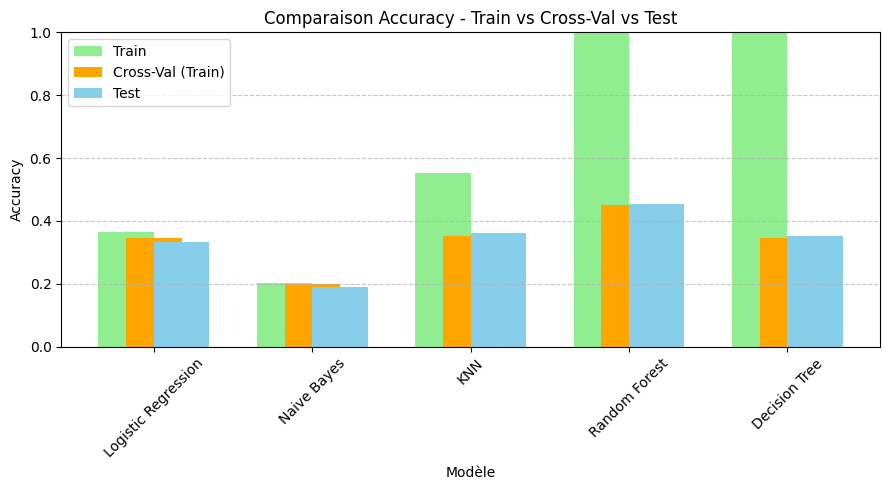

In [15]:
# Entraînement et évaluation
print("Nom du modèle       | Accuracy train | Accuracy test")
for i in range(n):
    print(f"{model_names[i]:20} | {acc_train[i]:.3f}         | {acc_test[i]:.3f} ")

# Histogramme train vs test
x = range(n)
bar_width = 0.35

plt.figure(figsize=(9,5 ))
plt.bar(x, acc_train, width=bar_width, label='Train', color='lightgreen')
plt.bar([p + bar_width/2 for p in x], acc_cv, width=bar_width, label='Cross-Val (Train)', color='orange')
plt.bar([p + bar_width for p in x], acc_test, width=bar_width, label='Test', color='skyblue')

plt.xlabel('Modèle')
plt.ylabel('Accuracy')
plt.title('Comparaison Accuracy - Train vs Cross-Val vs Test')
plt.xticks([p + bar_width/2 for p in x], model_names, rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analyse des performances des modèles de classification

Pour observer si notre modèle a été surentrainé ou non, on peut faire une comparaison des accuracy sur le train, la cross-validation sur train, et le test set. La valeur de cross validation (orange) est censé nous donner une valeur équivalente à la valeur d'accuracy approximative sur mon test set (bleu). Tandis que si la valeur de d'accuracy sur mon train set (vert) est nettement supérieur à celui de mon test set ( bleu) c'est que le modèle a été sur-entraîné sur mon train set et que l'on pourrais peut être généralisé un peu plus le modèle.

**Logistic Regression** : Pour la logistique régression, on n'oberve pas d’overfitting détecté : les scores train, CV et test sont très proches (~0.60).
En revanche le score n'est pas sufisamment élevé.\
**Naive Bayes** : Pour la Naive Bays régression, on n'oberve pas d’overfitting mais un score très faible.\
**K-Nearest Neighbors (KNN)** : Il nous donne un plutôt bon score mais le modèle est légèrement surentrainé. L'accuracy sur le test set autour de 0.40
 **Random Forest** : C'est le meilleur modèle jusque là mais on a problème d'Overfit. La différence entre les résultats du train set (vert) et test set (jaune) trop élevée. La régularisation de ce modèle est un aspect à explorer

### Analyse des performances de la Régression Logistique

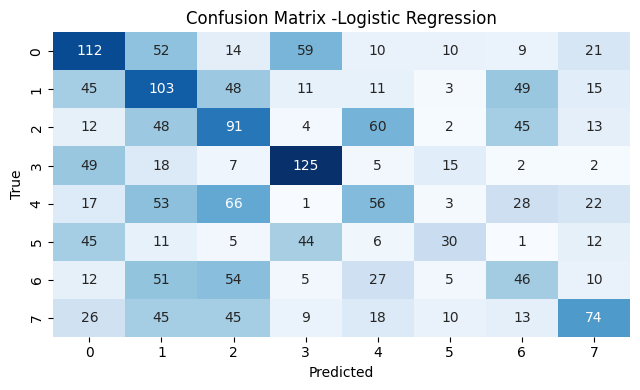

In [16]:
name = 'Logistic Regression'
cm = confusion_matrix(y_test, y_test_preds[name])
plt.figure(figsize=(6.5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix -" + name)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()




#### Performances générales

Sur l’histogramme comparatif, la régression logistique obtient une accuracy d’environ 0.36 sur le jeu d’entraînement, et une accuracy très proche sur les jeux de test et de validation croisée (autour de 0.34–0.35). Cette stabilité des performances indique que le modèle ne surapprend pas : il est régulier mais limité en capacité à modéliser la complexité du problème.

#### Analyse de la matrice de confusion

L’analyse plus fine de la matrice de confusion montre que certaines classes sont relativement bien prédites (notamment la classe 0,1,2), mais les classes prédites sont fréquemment confondues. Par exemple, les classes 0, 1 et 3 ont beaucoup de confusion mutuelle. En effet, le modèle beaucoup d'élments de classe 0,1 et 2.
Cela indique que le modèle ne parvient pas à séparer efficacement certaines catégories proches, ce qui est typique d’un modèle linéaire qui n’utilise que des frontières de décision planes.

#### Limites du modèle

La régression logistique est un modèle linéaire, ce qui la rend peu adaptée aux jeux de données où les classes ne sont pas séparables par des frontières linéaires. Elle a également du mal à capturer des interactions complexes ou non linéaires entre les variables.

Elle peut donc sous-apprendre si les données présentent beaucoup de variabilité, de redondances ou des relations implicites complexes.
On pourrais aussi analyser les coefficients de ce modèle car les coefficients corrélés positives et négatives nous permettent d'avoir plus d'information sur l'impact des features. Ici je ne le fait pas car, j'ai des variables OneHotEncore et ce serait non lisible.


#### Améliorations possible du modèle

Pour améliorer le modèle, on va essayer d'utiliser un grid search pour déterminer les meilleurs paramètres. Nous allons aussi plus tard faire une analyse des données avec des données avec des classes plus équilibrées, afin d'éviter de trop sur-prédire des classes. L'ajout de features polynomiale pourrait être aussi efficace dans l'analyse.

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Meilleurs hyperparamètres : {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleure accuracy moyenne (cross-val) : 0.3460
Accuracy sur le test set : 0.3245
Precision macro sur le test set : 0.3345

Rapport de classification :

              precision    recall  f1-score   support

           0       0.36      0.40      0.38       287
           1       0.26      0.35      0.30       285
           2       0.27      0.33      0.29       275
           3       0.47      0.54      0.51       223
           4       0.28      0.22      0.25       246
           5       0.37      0.16      0.22       154
           6       0.23      0.20      0.22       210
           7       0.44      0.32      0.37       240

    accuracy                           0.32      1920
   macro avg       0.33      0.31      0.32      1920
weighted avg       0.33      0.32      0.32      1920



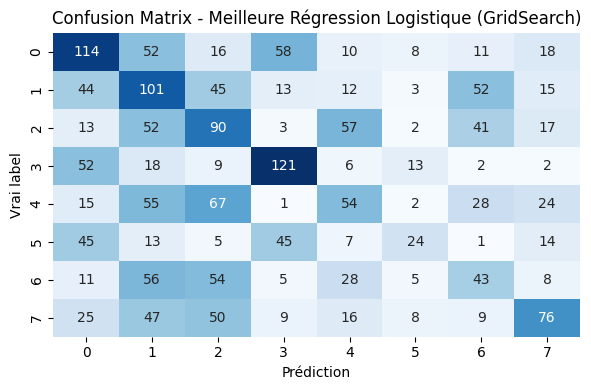

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Définir la grille des hyperparamètres
param_grid = {
    'penalty': [ 'l2'],
    'C': [ 0.1, 1, 10],
    'solver' : ["liblinear"]
}

# Initialisation du modèle
log_reg = LogisticRegression()

# Grid Search avec validation croisée
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Entraînement sur les données prétraitées
grid_search.fit(X_train_pp, y_train)

# Meilleurs paramètres et score
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print(f"Meilleure accuracy moyenne (cross-val) : {grid_search.best_score_:.4f}")

# Évaluation sur le jeu de test
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_pp)

acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"Accuracy sur le test set : {acc:.4f}")
print(f"Precision macro sur le test set : {prec:.4f}")
print("\nRapport de classification :\n")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Meilleure Régression Logistique (GridSearch)")
plt.xlabel("Prédiction")
plt.ylabel("Vrai label")
plt.tight_layout()
plt.show()

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Génération des features polynomiaux (degré 2 par défaut)
poly_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=1000)
)

# Entraînement
poly_model.fit(X_train_pp, y_train)

# Prédiction
y_pred = poly_model.predict(X_test_pp)

# Évaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Accuracy (test) : {acc:.4f}")
print(f"Precision (macro) : {prec:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy (test) : 0.3484
Precision (macro) : 0.3528

Rapport de classification :
              precision    recall  f1-score   support

           0       0.35      0.38      0.36       287
           1       0.29      0.31      0.30       285
           2       0.34      0.38      0.36       275
           3       0.45      0.50      0.47       223
           4       0.32      0.30      0.31       246
           5       0.37      0.30      0.33       154
           6       0.23      0.22      0.23       210
           7       0.47      0.36      0.41       240

    accuracy                           0.35      1920
   macro avg       0.35      0.35      0.35      1920
weighted avg       0.35      0.35      0.35      1920



## Gaussian NB

Les prédictions effectuées par la méthode bayésienne naîve donnent un très mauvais score. Ce modèle suppose des features indépendantes, ce qui n'est pas tout à vrai dans le domaine étudié.
Le modèle prédit très mal la vraie classe. Deplus, doivint suivre une loi Normale ce qui n'est pas toujours le cas.

Observation : Diagonale très faible (peu de vrais positifs)	


## K Neighbors Classifier (k=5)

On remarque que le KNN (k=5) donne un accuracy score plutôt BON. Comme le modèle de régression logistique, les classes 3 à 9 sont encore très mal reconnues, souvent prédictes comme 0,1 ou 2. Mais on observe une répartition des valeurs prédites beaucoup plus équilibré et dispersé que la régression logistique, ce qui implique une précision plus élevée.
Cependant, on observe une répartition des valeurs prédites beaucoup plus confuses parmi les classes majoritaires 1,2 et 3 ( précision moins élevée pour ces classes.


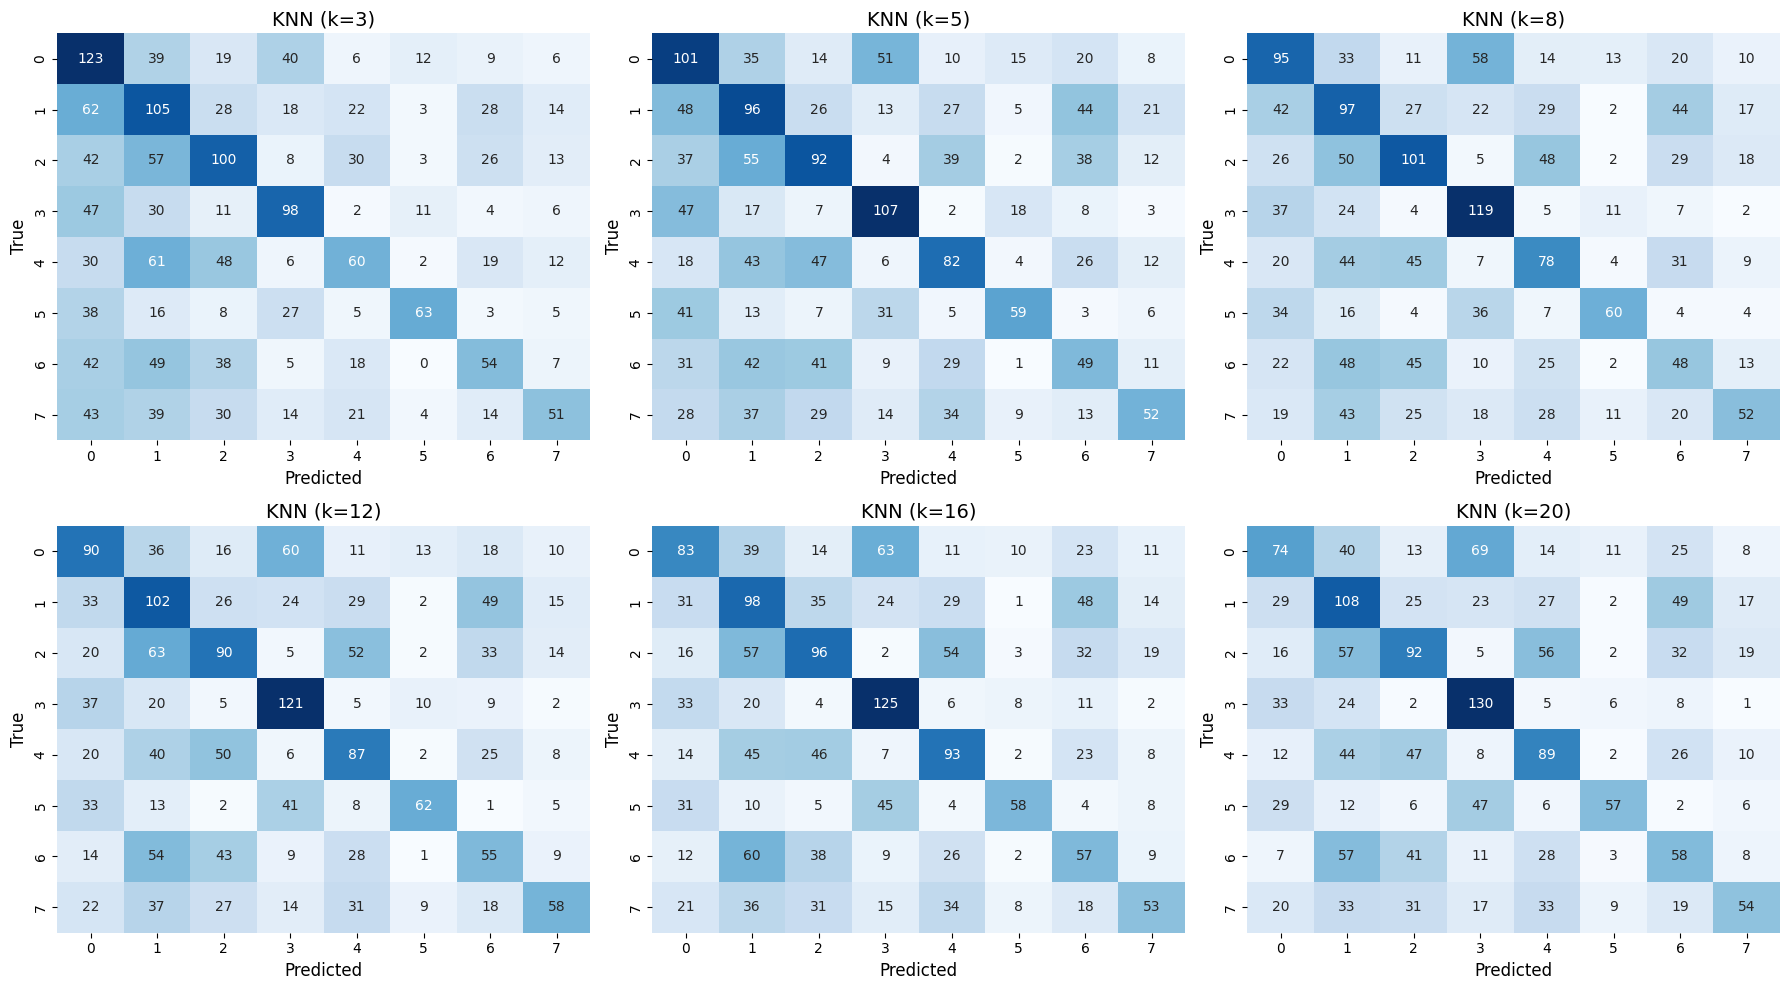

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ks = [3, 5, 8, 12, 16, 20]
accuracy = []
precision = []
conf_matrices = []

# Entraînement + stockage des métriques et matrices
for k in ks:
    modelKNN = KNeighborsClassifier(k)
    modelKNN.fit(X_train_pp, y_train)
    y_pred = modelKNN.predict(X_test_pp)

    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

# Affichage en subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 lignes, 3 colonnes
axes = axes.flatten()

for i, k in enumerate(ks):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f"KNN (k={k})", fontsize=14)
    axes[i].set_xlabel("Predicted", fontsize=12)
    axes[i].set_ylabel("True", fontsize=12)

plt.tight_layout()
plt.show()


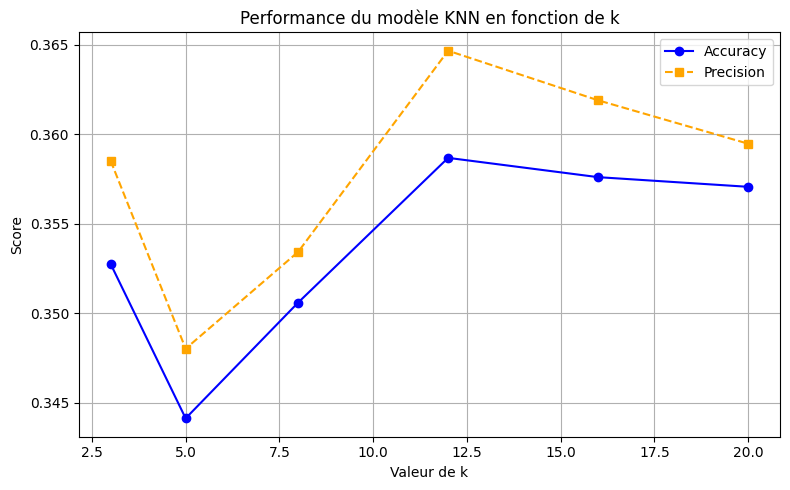

In [29]:
# Tracé
plt.figure(figsize=(8, 5))
plt.plot(ks, accuracy, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.plot(ks, precision, marker='s', linestyle='--', color='orange', label='Precision')

plt.title("Performance du modèle KNN en fonction de k")
plt.xlabel("Valeur de k")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Résultats de l'analyse

On souhaite maximiser la valeur de l'accuracy mais aussi celle de la precision. Malgré que la valeur de l'accuracy soit croissant en fonction de k , on veut aussi obtenir une précision élevée. Or on obtient un pic en k=8. En effet, avoir une précision élevée permet de confirmer la valadité de la réponse. En effet, si à une classe donnée, le modèle prédit cette classe, alors une précision élevée, implique qu'elle a plus de chance que la prédiction soit correcte.
Ainsi la valeur de k=12 est celui qui donne le modèle le plus performant

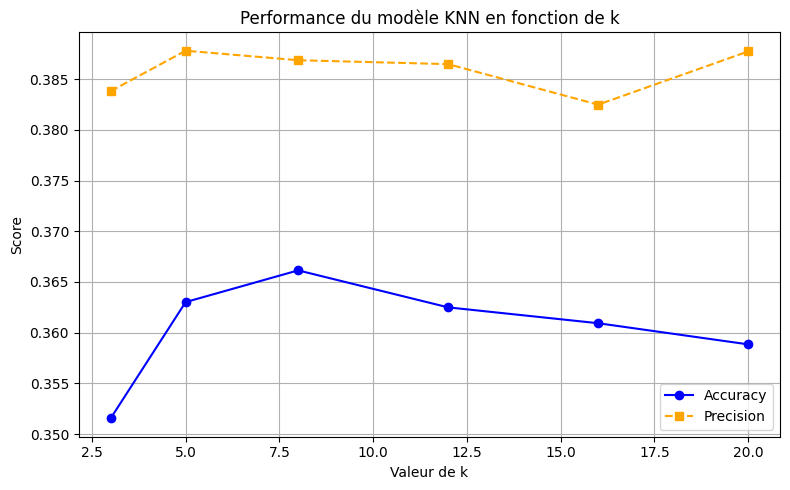

In [21]:
# Tracé
plt.figure(figsize=(8, 5))
plt.plot(ks, accuracy, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.plot(ks, precision, marker='s', linestyle='--', color='orange', label='Precision')

plt.title("Performance du modèle KNN en fonction de k")
plt.xlabel("Valeur de k")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Random Forest ( Decision Trees )

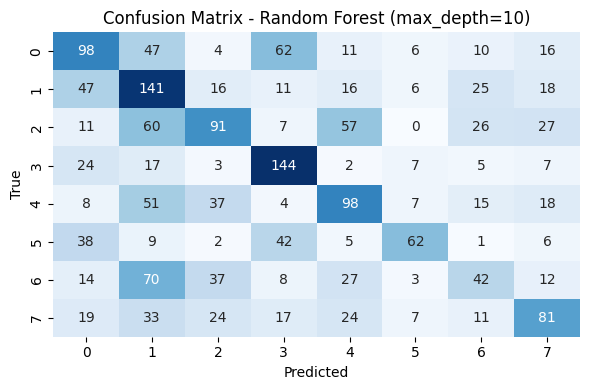

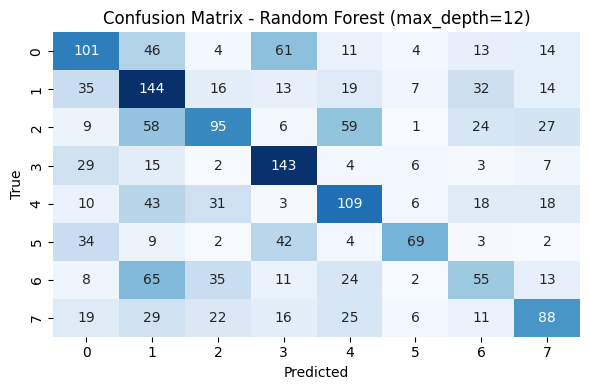

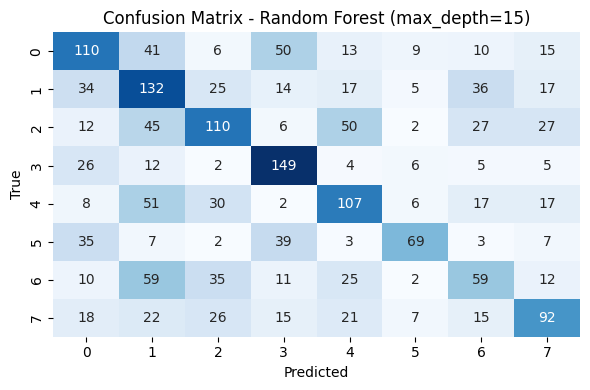

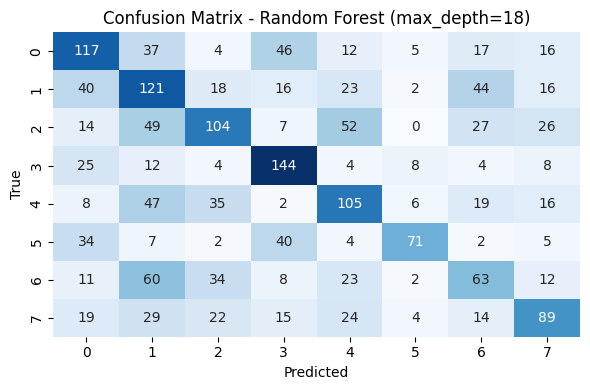

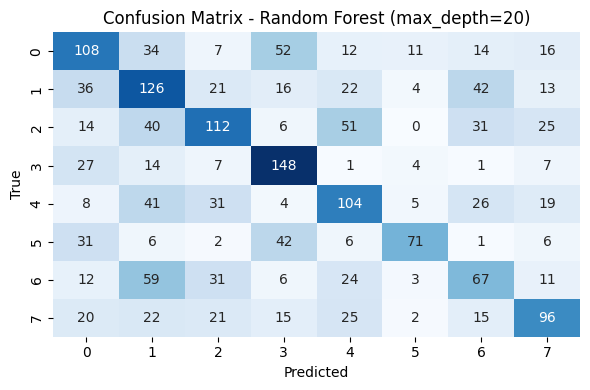

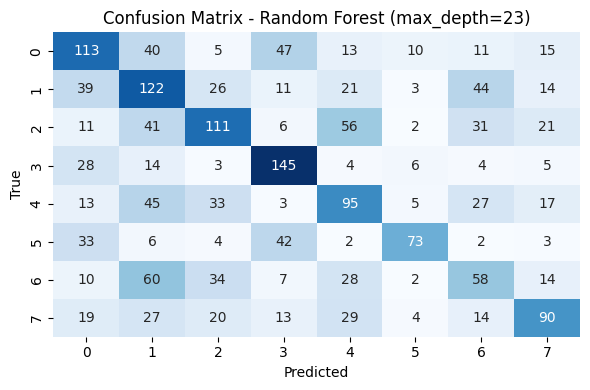

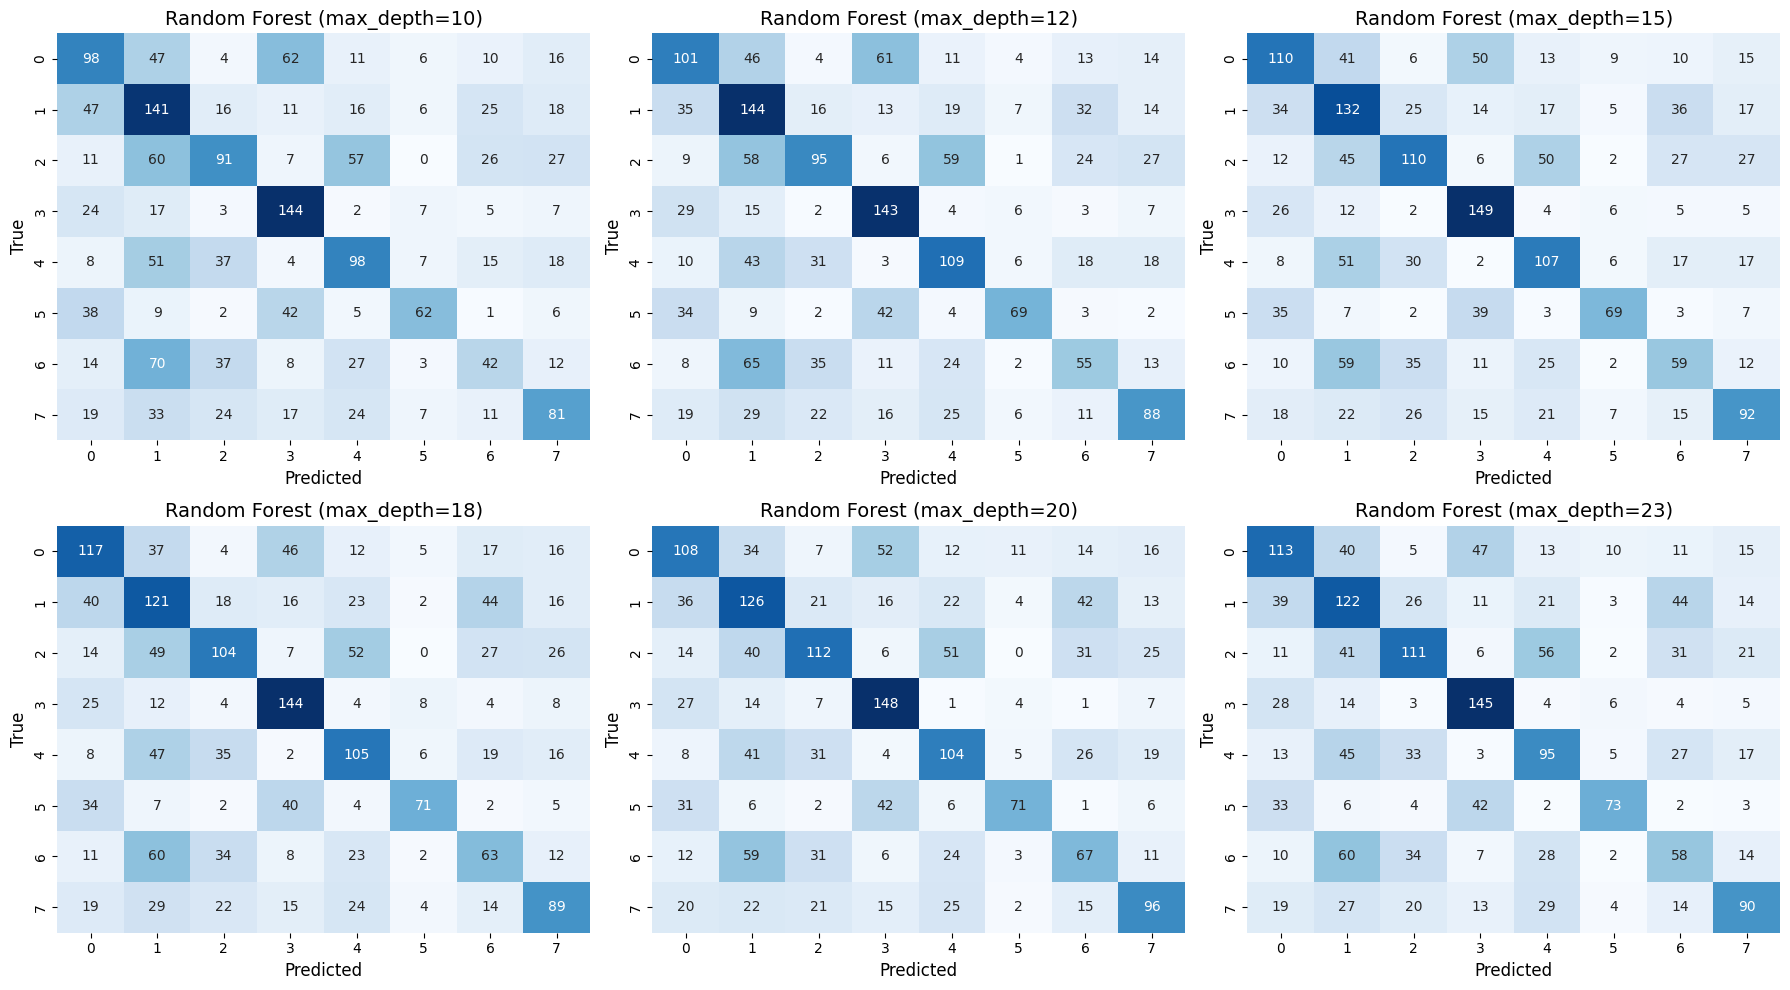

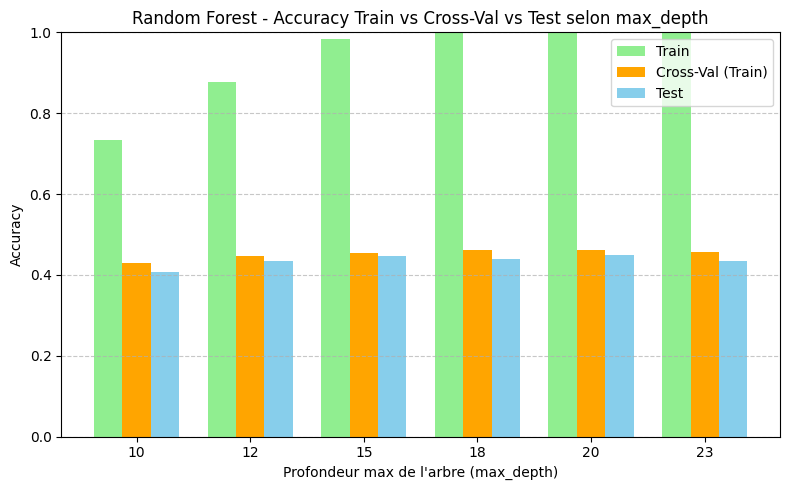

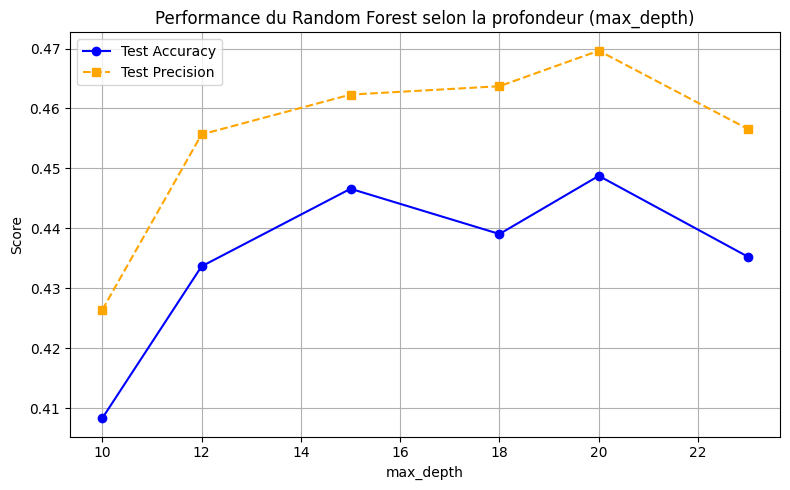

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Profondeurs testées
depths = [ 10,12, 15, 18, 20, 23 ]

acc_train = []
acc_test = []
acc_cv = []
precision_test = []
conf_matrices = []

# Évaluation pour chaque profondeur
for d in depths:
    modelRF = RandomForestClassifier(max_depth=d, n_estimators=100,random_state=42,min_samples_split=2)
    modelRF.fit(X_train_pp, y_train)

    y_train_pred = modelRF.predict(X_train_pp)
    y_test_pred = modelRF.predict(X_test_pp)

    acc_train.append(accuracy_score(y_train, y_train_pred))
    acc_test.append(accuracy_score(y_test, y_test_pred))
    acc_cv.append(np.mean(cross_val_score(modelRF, X_train_pp, y_train, cv=5, scoring='accuracy')))
    precision_test.append(precision_score(y_test, y_test_pred, average='macro', zero_division=0))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    conf_matrices.append(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - Random Forest (max_depth={d})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Subplots des matrices de confusion (2 lignes × 3 colonnes)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 6 subplots
axes = axes.flatten()

for i, d in enumerate(depths):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f"Random Forest (max_depth={d})", fontsize=14)
    axes[i].set_xlabel("Predicted", fontsize=12)
    axes[i].set_ylabel("True", fontsize=12)

plt.tight_layout()
plt.show()

# === Histogramme final : Train / Cross-Val / Test ===
bar_width = 0.25
x = np.arange(len(depths))

plt.figure(figsize=(8, 5))
plt.bar(x, acc_train, width=bar_width, label='Train', color='lightgreen')
plt.bar(x + bar_width, acc_cv, width=bar_width, label='Cross-Val (Train)', color='orange')
plt.bar(x + 2 * bar_width, acc_test, width=bar_width, label='Test', color='skyblue')

plt.xlabel("Profondeur max de l'arbre (max_depth)")
plt.ylabel("Accuracy")
plt.title("Random Forest - Accuracy Train vs Cross-Val vs Test selon max_depth")
plt.xticks(x + bar_width, depths)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Courbes finale : Accuracy & Precision ===
plt.figure(figsize=(8, 5))
plt.plot(depths, acc_test, marker='o', linestyle='-', color='blue', label='Test Accuracy')
plt.plot(depths, precision_test, marker='s', linestyle='--', color='orange', label='Test Precision')

plt.title("Performance du Random Forest selon la profondeur (max_depth)")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Analyse synthétique des performances du Random Forest selon `max_depth`

Le modèle le plus performant d'après les premiers résultats est le Random Forest. C'est un modèle qui utilise une combinaison de plusieurs décision trees pour les mélanger, et choisir les meilleurs attributs à séparer. C'est cohérent avec notre analyse car, on pourrait se dire qu'aujourd'hui, la classification des genres musicaux se fait traditionnement par des règles de musique.

### Observation
Pour cela, on a évalué le modèle RandomForestClassifier en faisant varier la profondeur maximale des arbres entre 10 et 25. Les résultats montrent que l’accuracy et la précision sur le jeu de test augmentent avec la profondeur jusqu’à atteindre un maximum vers "max_depth = 20". Au-delà de cette valeur, les performances stagnent ou régressent légèrement.

### Overfitting
L’analyse des résultats sur les jeux d’entraînement, de validation croisée et de test montre un surapprentissage des données : l’accuracy atteint 1.00 sur le jeu d’entraînement dès "max_depth = 20", tandis que les performances sur le test plafonnent autour de 0.48–0.50. L’écart grandissant entre l’accuracy sur le train et le test à partir de max_depth = 15 signale une perte de capacité de généralisation.

En conclusion, les profondeurs max_depth = 15 ou 20 offrent le meilleur compromis entre complexité du modèle et performance généralisable. Pour améliorer la stabilité et réduire l’overfitting, il est recommandé de régulariser davantage en ajustant les paramètres min_samples_leaf`, min_samples_split et max_features, et d'utiliser GridSearchCV pour affiner ces choix automatiquement. Le modèle avec max_depth = 25, bien qu’expressif, est à éviter sans régularisation appropriée car il tend à surapprendre les données d’entraînement.


## NB ( SVM )

J'aurais voulu utiliser la méthode Support Vector Machine car elle permet de modéliser des modèles complexes qui ne sont pas nécessairement linéairement séparable ce qui est parfait pour notre modèle, où on pourrait se dire que certains points de différentes classes peuvent se chevaucher. En utilisant une classification polynomiale, ou gaussienne , on pourrait avoir de bons résultats. Mais la taille de notre dataset est trop élevé ce qui rend l'exécution trop lente est efficace. Il faudrait réduit la taille de notre dataset

## Conclusion Premiere Partie

Le meilleur modèle observé et celui du Random Forest. KNN nous donne aussi un bon résultat.
La raison est que les données musicales (features audio, rythme, tonalité, danceability, etc.) sont fortement non linéaires et interdépendantes.
Les modèles trop peu complexes comme les modèles linéaires (la régression logistique) n’est pas capable de capturer ces relations subtiles.
Ainsi, Random Forest est un modèle non linéaire basé sur une collection d’arbres de décision, il s’adapte bien à des patterns complexes.

# Deuxieme Partie

Dans cette deuxième partie, nous avons faire l'analyse avec un dataset qui contient une répartion des classes beaucoup plus équilibrées que la première, ce qui permet d'éviter le biais souvent courant.

In [23]:


# Comptage initial des genres
genre_counts = spotify_df['Main_genre'].value_counts()
total_desired = 12000  # taille cible

# On garde un déséquilibre léger basé sur les proportions initiales
# Mais on "lisse" vers l'équilibre : on redistribue les proportions
base_proportions = genre_counts / genre_counts.sum()

# On utilise un facteur de lissage : on évite qu'une classe dépasse trop les autres
# Ici on "lisse" à mi-chemin entre l'équilibre pur et les proportions réelles
equal_proportion = 1 / len(genre_counts)
smooth_proportions = 0.5 * base_proportions + 0.5 * equal_proportion

# On convertit ça en effectif pour chaque genre
target_counts = (smooth_proportions * total_desired).astype(int)

# Affichage des cibles par genre
print("Cibles équilibrées (légèrement déséquilibrées) :")
for genre in genre_counts.index:
    print(f"{genre:17} : {target_counts[genre]} morceaux")

# Échantillonnage
import pandas as pd

balanced_samples = []

for genre in genre_counts.index:
    genre_df = spotify_df[spotify_df["Main_genre"] == genre]
    count = target_counts[genre]
    sampled = genre_df.sample(n=min(count, len(genre_df)), random_state=42)
    balanced_samples.append(sampled)

spotify_df_balanced = pd.concat(balanced_samples, ignore_index=True)

print(f"\nTaille finale du dataset équilibré : {len(spotify_df_balanced)}")
print("\nRépartition réelle :")
print(spotify_df_balanced['Main_genre'].value_counts(normalize=True).round(3))

#spotify_df_balanced.to_csv("spotify_dataset_classbalanced.csv", index=False)

Cibles équilibrées (légèrement déséquilibrées) :
hip hop           : 1638 morceaux
pop               : 1638 morceaux
rock              : 1638 morceaux
alternative rock  : 1485 morceaux
trap              : 1459 morceaux
pop rock          : 1454 morceaux
electronic        : 1449 morceaux
rap               : 1236 morceaux

Taille finale du dataset équilibré : 11583

Répartition réelle :
Main_genre
hip hop             0.141
pop                 0.141
rock                0.141
alternative rock    0.127
trap                0.123
pop rock            0.122
electronic          0.121
rap                 0.084
Name: proportion, dtype: float64


In [24]:
spotify_df_2 = spotify_df_balanced.copy()
# On garde seulement 80% des données à extraire
spotify_df_80, spotify_df_20= train_test_split(spotify_df_2, test_size=0.2, random_state=42)


In [25]:
y = spotify_df_80["Main_genre_index"]
X = spotify_df_80[numerical_features + categorical_features]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2 )

preprocessing.fit(X_train)
X_train_pp = preprocessing.transform(X_train)
X_test_pp = preprocessing.transform(X_test)


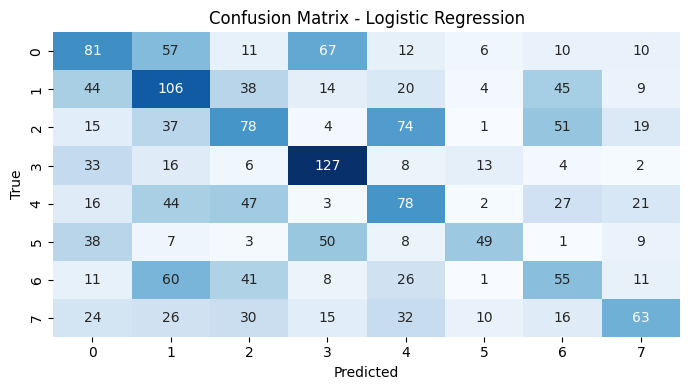

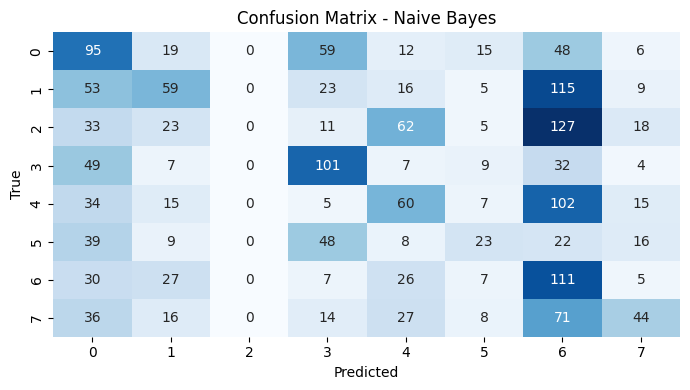

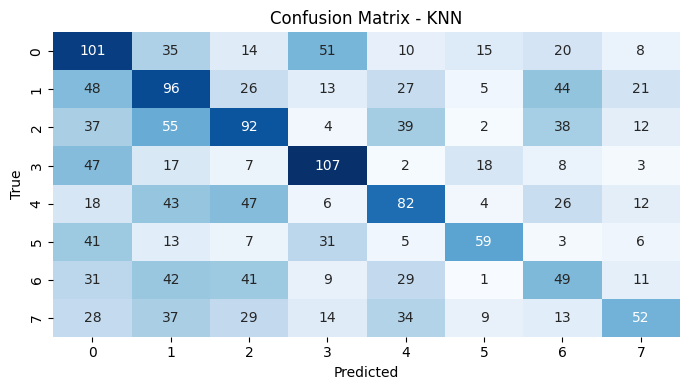

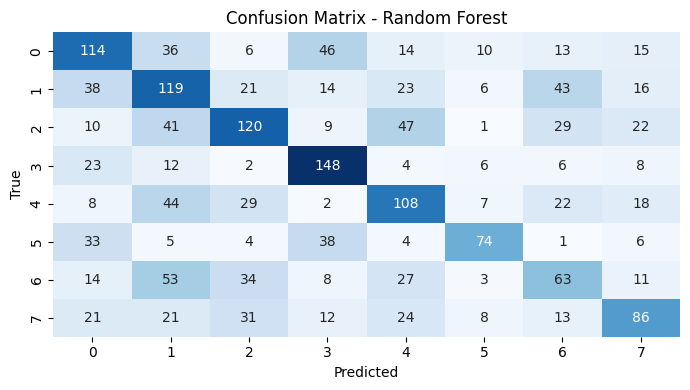

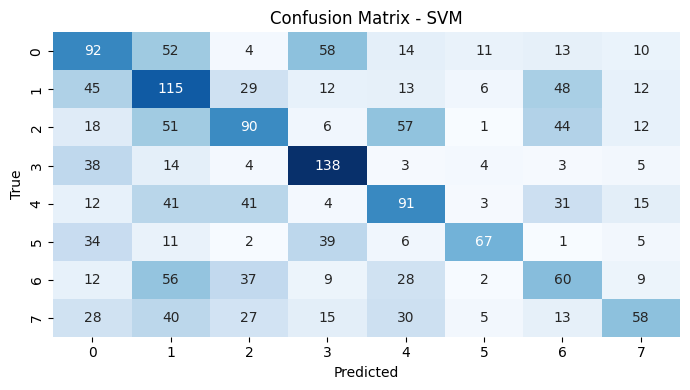

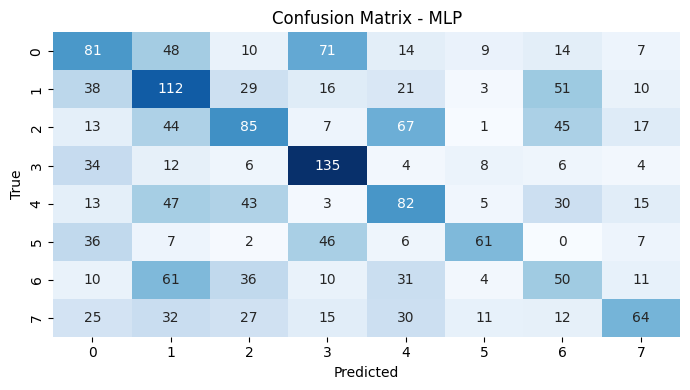

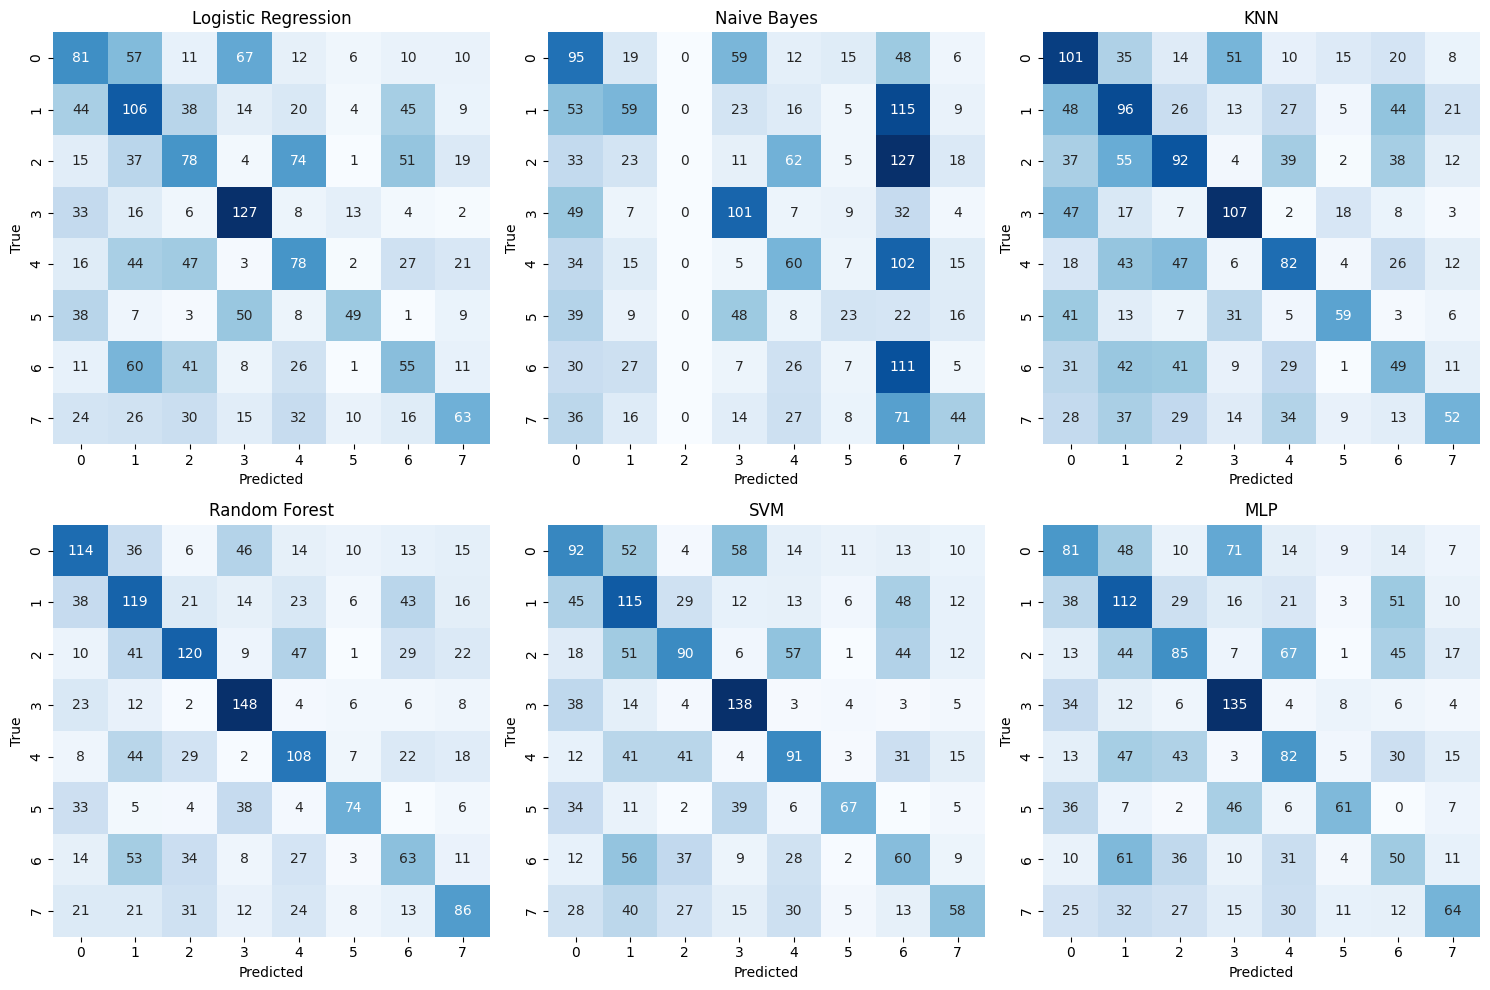

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns

# Modèles
models = [
    LogisticRegression(max_iter=1000),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5),
    RandomForestClassifier(n_estimators=100),
    SVC(kernel='poly', degree=3, C=1, coef0=1, gamma='scale'),
    #MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    MLPClassifier(hidden_layer_sizes=(50,),alpha=0.001,max_iter=200,early_stopping=True,n_iter_no_change=5,solver='adam',random_state=42)
]

model_names = [
    'Logistic Regression',
    'Naive Bayes',
    'KNN',
    'Random Forest',
    'SVM',  # ✅ Ajout du nom
    'MLP'
]

# Initialisation
n = len(models)
acc_train = [0] * n
acc_test = [0] * n
acc_cv = [0] * n
model_preci = [0] * n
model_recall = [0] * n
model_f1 = [0] * n
y_train_preds = dict()
y_test_preds = dict()

# Boucle sur les modèles
for i in range(n):
    name = model_names[i]
    models[i].fit(X_train_pp, y_train)
    y_train_pred = models[i].predict(X_train_pp)
    y_test_pred = models[i].predict(X_test_pp)

    # Stock des prédictions
    y_train_preds[name] = y_train_pred
    y_test_preds[name] = y_test_pred
    
    acc_train[i] = accuracy_score(y_train, y_train_pred)
    acc_test[i] = accuracy_score(y_test, y_test_pred)
    if(name=="SVM" or name=="MLP"):
        acc_cv[i] = 0
    else:
        acc_cv[i] = np.mean(cross_val_score(models[i], X_train_pp, y_train, cv=5, scoring='accuracy'))

    model_preci[i] = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    model_recall[i] = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    model_f1[i] = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(7, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {model_names[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Affichage des matrices de confusion en subplots
rows = 2
cols = math.ceil(n / rows)  # arrondi supérieur : ici 3 colonnes

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

axes = axes.flatten()  # pour accéder aux subplots avec axes[i]
for i in range(n):
    name = model_names[i]
    y_test_pred = y_test_preds[name]
    cm = confusion_matrix(y_test, y_test_pred)

    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# Masquer les subplots inutilisés (si n < rows*cols)
for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Nom du modèle       | Accuracy train | Accuracy test
Logistic Regression  | 0.360         | 0.344  
Naive Bayes          | 0.288         | 0.266  
KNN                  | 0.557         | 0.344  
Random Forest        | 1.000         | 0.449  
SVM                  | 0.575         | 0.383  
MLP                  | 0.414         | 0.361  


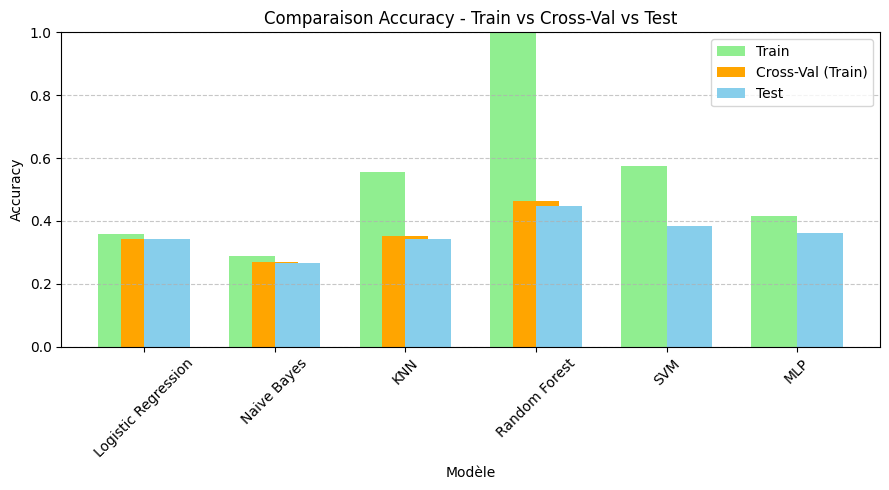

In [27]:
# Entraînement et évaluation
print("Nom du modèle       | Accuracy train | Accuracy test")
for i in range(n):
    print(f"{model_names[i]:20} | {acc_train[i]:.3f}         | {acc_test[i]:.3f}  " )

# Histogramme train vs test
x = range(n)
bar_width = 0.35

plt.figure(figsize=(9,5 ))
plt.bar(x, acc_train, width=bar_width, label='Train', color='lightgreen')
plt.bar([p + bar_width/2 for p in x], acc_cv, width=bar_width, label='Cross-Val (Train)', color='orange')
plt.bar([p + bar_width for p in x], acc_test, width=bar_width, label='Test', color='skyblue')

plt.xlabel('Modèle')
plt.ylabel('Accuracy')
plt.title('Comparaison Accuracy - Train vs Cross-Val vs Test')
plt.xticks([p + bar_width/2 for p in x], model_names, rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()